# Cookbook: Maximum Likelihood Estimator

In [644]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
# These are some parameters to make figures nice (and big)

plt.rcParams['figure.figsize'] = 16,8
plt.rcParams['text.usetex'] = True
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

# Application 1: Gutenberg-Richter Law

## Data: August 2016 Central Italy Earthquake

The Gutenberg-Richter Law describes the distribution of earthquake magnitude. It is usualyl written in terms of the total number of Earthquakes that occur in a given period in a given time frame. [Link: The Gutenberb-Richter law on wikipedia](https://en.wikipedia.org/wiki/Gutenberg%E2%80%93Richter_law#).

The Gutenberg-Richter law models the number of earthquakes as:

$$\log_{10} N = a-bM$$ 


Let's visualize the Gutenberg-Richter law using data for the aftershocks of the [August 2016 Central Italy Earthquake](https://en.wikipedia.org/wiki/August_2016_Central_Italy_earthquake).




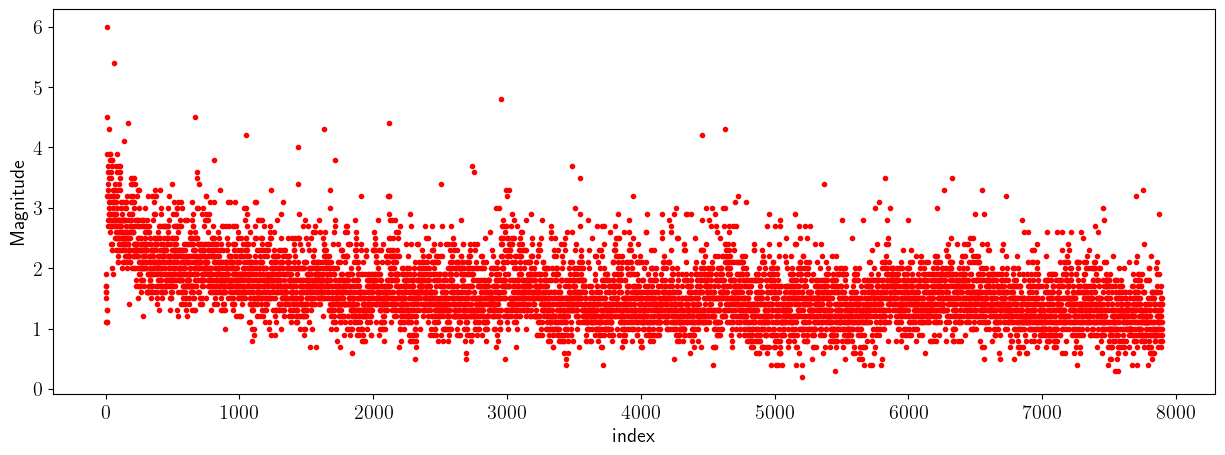

In [645]:
# Read in data into a pandas dataframe
df=pd.read_csv('https://raw.githubusercontent.com/cdds-uiuc/simles-book/main/content/Module02/data/2016_Central_Italy_Earthquake.csv')
df.head()
plt.plot(df.Magnitude,'r.');
plt.ylabel('Magnitude');
plt.xlabel('index');

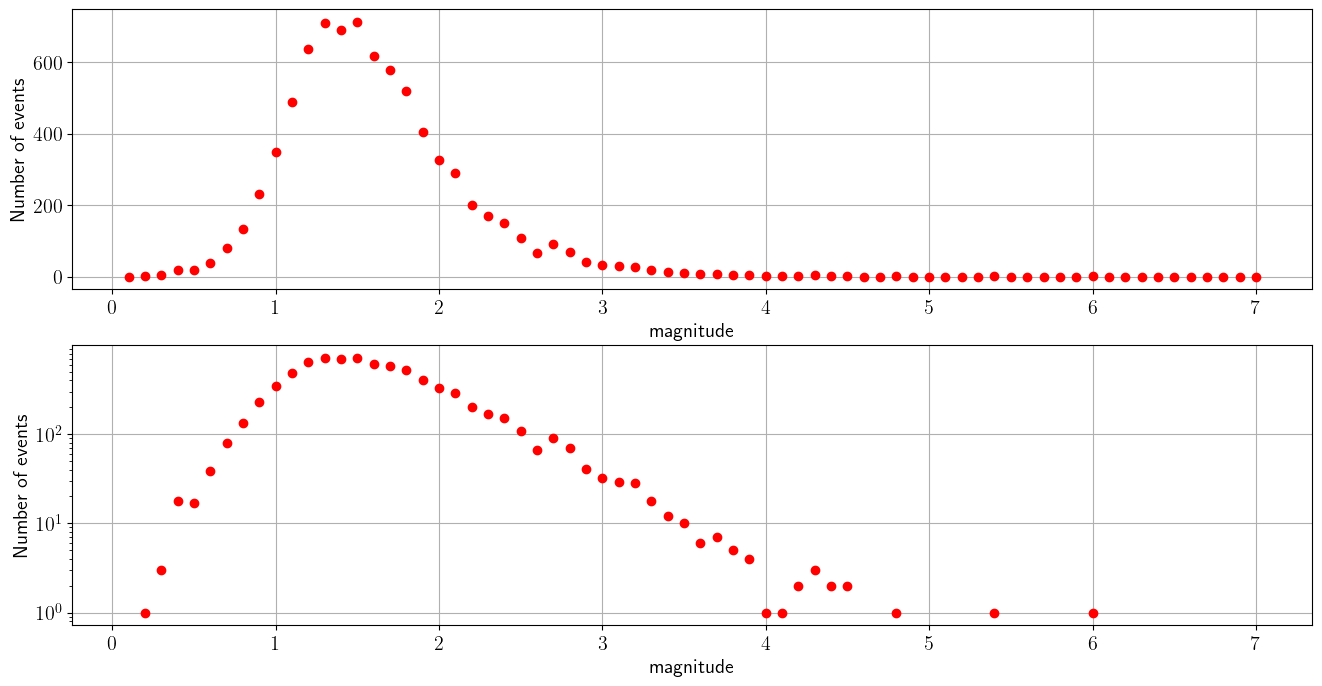

In [641]:
#now let's plot a histogram of the number of events as a function of magnitude.

#define the bins: 
#let's use bins that are 0.1 in width, so we can plot magnitude from 0.1 to 6.5 in increments of 0.1

#we want the bins centered on 0.1,0.2, and so on, so the bin edges must be 0.05, 0.15, 0.25, etc.
bin_edges=np.arange(0.05,7.15,0.1)

#let's save the bin centers as well for plotting.
# We can do that by averaging the values of the left bin edges and the right bin edges
bin_centers=bin_centers=(bin_edges[0:-1]+bin_edges[1:])/2

# we could also just define the bin centers as below
# but that is more error prone. It it safer to just compute the bin centers as a function of the bin edges
#bin_centers=np.arange(0.1,7.1,0.1)

histogram=np.histogram(df.Magnitude,bin_edges)
counts=histogram[0]

fig,axs=plt.subplots(2,1,figsize=[16,8])

#first let's plot the data on a regular axis
plt.subplot(2,1,1)
plt.plot(bin_centers,counts,'ro')
plt.grid()
plt.xlabel('magnitude');
plt.ylabel('Number of events');

#now, let's plot the data with the y-axis being logarithmic, since the G-R law is expressed in terms of the logarithm of N.
plt.subplot(2,1,2)
plt.plot(bin_centers,counts,'ro')

plt.yscale('log')
plt.grid()
plt.xlabel('magnitude');
plt.ylabel('Number of events');


You can see that for events larger than $M\approx 1.5$ the data follows a linear slope in the plot on the logarithmic axis. This is what you would expect since $\log_{10}N=a-bM$. At magnitudes less than $1.5$ we are running into recorder bias. The instruments cannot reliably detect earthquakes smaller than $M=1.5$, so they are not recorded. 

If we ignore the data below $M_{min}=1.5$ we can write the Gutenberg-Richter law as: 

$$\log_{10}N=a-b(M-M_{min})$$

Let's plot that below:

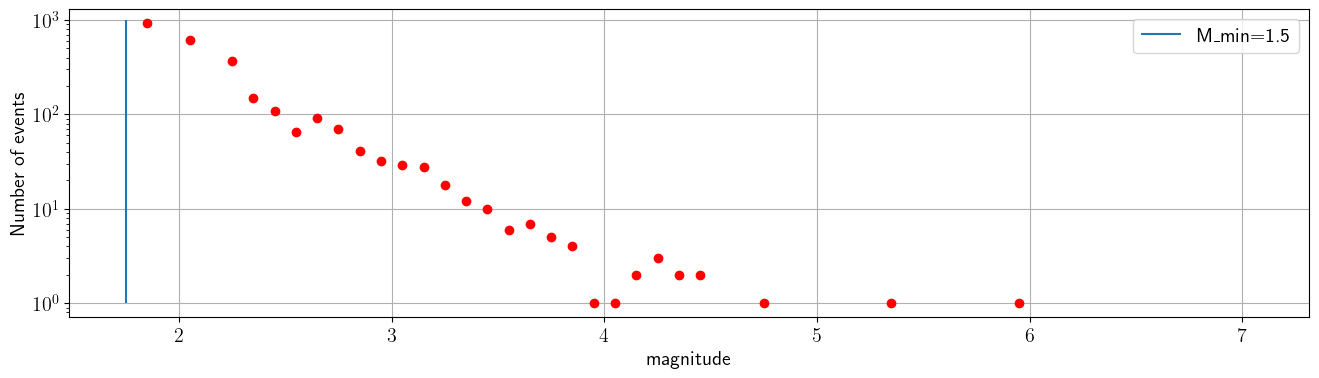

In [628]:
M_min=1.75
M=df.Magnitude.values;
M=M[M>M_min]

bin_edges=np.arange(M_min+0.05,7.15,0.1)
bin_centers=bin_centers=(bin_edges[0:-1]+bin_edges[1:])/2
histogram=np.histogram(M,bin_edges)
counts=histogram[0]

fig,axs=plt.subplots(1,figsize=[16,4])
plt.plot(bin_centers,counts,'ro')
plt.grid()
plt.yscale('log')
plt.vlines(M_min,1,1000,label='M_{min}=1.5')
plt.xlabel('magnitude')
plt.ylabel('Number of events')
plt.legend()


## Interpretation of the G-R law


What does the Gutenberg-Richter law tell us:
-  The parameter $a$ describes the *seismicity* of an area (how many total events occur in a given period)
-  the parameter *b* describes the *distribution* of earthquakes in terms of their magnitude.

The slope $b$ tells us the relative frequency of events:

$$ \frac{N(M_i)}{N(M_j)}=\frac{10^{a-bM_i}}{10^{a-bM_j}}=10^{b(M_j-M_i)}$$

For example, this tells us that that there are $10^b$ $M=4$ every magnitude $M=5$ event:

$$ \frac{N(M=4)}{N(M=5)}=\frac{10^{a-bM_i}}{10^{a-bM_i}}=10^{b(5-4)}=10^b$$

Many places have b-values around 1, meaning that there is around one Magnitude $M=5$ event for every 10 Magnitude $M=6$ events; one Magnitude $M=6$ event for every Magnitude $M=5$ event and so on. 

## Normalization: G-R law as distribution
Note that the G-R law is written in terms of number of events $N$ so it is not actually a proper distribution, since it does not sum to 1. To write it as a distribution, we would need to write it as: 

$$N(M)=N_{tot}p(M)$$ 

where $N_{tot}$ is the total number of Earthquakes above $M_{min}$, and $p(M)$ is a probabiltiy density function that integrates to 1. This way, the G-R law would integrate to $N_{tot}$. 

Setting the condition that $N(M)$ integrates to the $N_{tot}$, we get:

$$N_{tot}=E(M)=\int_{M_{min}}^{\infty}N(M)dM=\int_{M_{min}}^{\infty}10^{a-b(M-M_{min}}dM=\frac{10^{a}}{\ln10\cdot b}$$

$$ a=\log{10} N_{tot}+\log_{10}b \ln10$$ 

$$ N=N_{tot}\cdot b \cdot \ln10\cdot10^{-b(M-M_{min})}=N_{tot}\cdot p_{GR}(M)$$

What we have done is reparametrized the G-R law from a function of $a,b$ to a function of $N_{tot}$ and $b$, which, in turns, allowed us to write it as a probability distribution function times a normalization constant. Now we can do some statistics. 

## Maximum Likelihood Estimator for G-R

The goal is to fit the Gutenberg-Richter law for Earthquakes of magnitude larger than $M_{min}=1.5$. This can be done by doing a linear regression, or least squares fit on the plot above, but as we shall see in next lecture, that is ill advised, as it tends to put too much weight on the high-magnitude earthquakes for which we have very few data points. 

Instead, we shall use the maximum-likelihood approach. 

The likelihood of the data (i.e. the measured magnitudes $x=\{M_i\}$), given a value of the parameter $\theta={b}$ is: 

$$\mathcal L =p(x|\theta)=p(\{M_i\}|b)=\prod_i p(M_i|\theta)=\prod_i b\ln (10)\cdot 10^{-b(M_{min}-M)}$$ 

where we have assumed that the magnitudes of different events are independent (a potentially dubious approximation). The log-likelihood becomes:

$$\log\mathcal{L}=\sum_i \ln b+\ln(\ln10)+\ln10\cdot (b\cdot (M_{min}-M_i))$$

$$\log\mathcal{L}=N_{tot}\ln b+N_{tot}\ln(\ln10)+\ln10\sum_ib\cdot (M_{min}-M_i)$$

Setting $d\log\mathcal{L} /db =0$ we get

$$0=\frac{n}{\hat b_{mle}}-\sum\ln 10\left(M_{min}-M\right)$$

$$\hat b_{mle}=\frac{N_{tot}}{\sum\ln 10\left(M_{min}-M\right)}$$

Let's compute the MLE estimator

In [642]:


M_min=1.5
M=df.Magnitude.values;
M=M[M>M_min]

Ntot=len(M)

bhat=Ntot/np.sum( np.log(10)*(M-M_min))

print(bhat)


0.828204706881597


Now let's plot the distribution we estimated via the MLE 

$$\hat p_{GR}= \hat b_{mle} \cdot \ln10\cdot10^{-\hat b_{mle} (M-M_{min})}$$

and compare with the distribution of earthquakes $> M_{min}$ in the data:

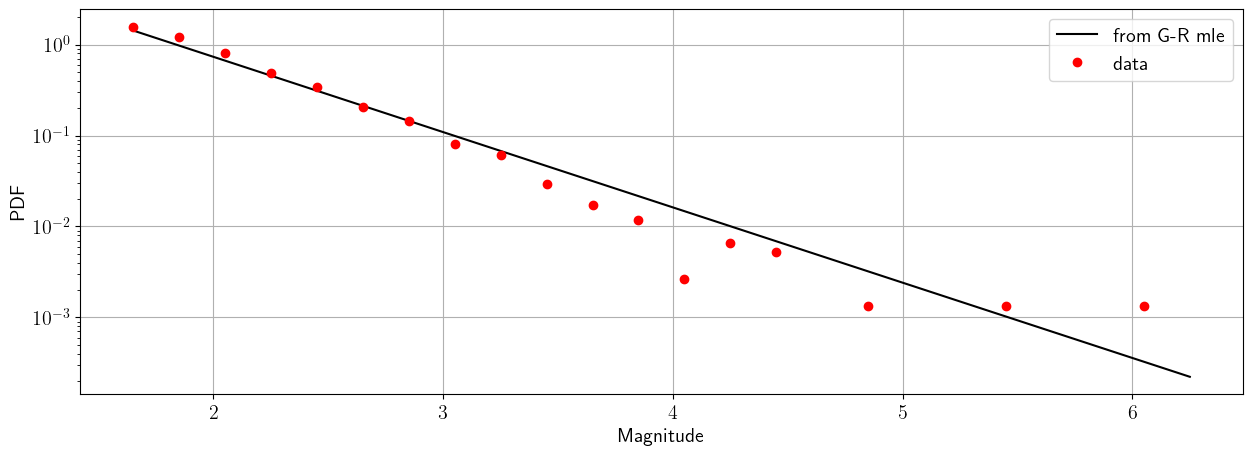

In [643]:
bin_edges=np.arange(M_min+0.05,6.45,0.2)
bin_centers=bin_centers=(bin_edges[0:-1]+bin_edges[1:])/2


X=bin_centers
pdf=bhat*np.log(10)*10**(bhat*(M_min-X))
histogram=np.histogram(M,bin_edges,density='true')
freq=histogram[0]

plt.plot(X,pdf,'k-',label='from G-R mle')
plt.plot(bin_centers,freq,'ro',label='data')
plt.yscale('log')
plt.grid()
plt.xlabel('Magnitude')
plt.ylabel('PDF')
plt.legend()

## Relation to Pareto distribution
Since the magnitude is itself a logarithmic function of the seismic wave amplitude, $M=\log_{10}A$, this means that the G-R law is a type of Pareto distribution, with pdf:

$$p(A)=p(A)=\frac{bA_{min}^{b}}{A^{b+1}}$$ 

to show this, we can set $M=\log_{10}A$ in the equation for $p_{GR}$ and use the formula for reparameterizing a pdf:

$$ p(M)=p(A)\frac{dA}{dM}$$

The MLE estimator for the Pareto distribution can be found, [e.g. on Wikipedia](https://en.wikipedia.org/wiki/Pareto_distribution#Statistical_inference) as:

$$\hat{b}_{mle}=\frac{N_{tot}}{\sum_i \ln (A_i/A_{min})}$$

Setting $A_i=10^{M_i}$ allows us to recover the MLE formula we computed earlier

# Application 2: Precip return times for Hurricane Harvey
## Houston precipitation
In the wake of Hurricane Harvey, many have described the assocaited flooding as a "500-year event". How can this be, given that in most places there are only a few decades of data available? In this exercise we apply a simple (and most likely wrong) methodology to estimate _return periods_, and comment on the wisdom of that concept.

Let's load and get to know the data. We are looking at daily precip data (in cm) at Beaumont Research Center and Port Arthur, two of the weather stations in the Houston area that reported very high daily precip totals. 

The data comes from NOAA GHCN:<br>
https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USC00410613/detail<br>
https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00012917/detail


In [623]:
# read data and take a cursory look
df=pd.read_csv('https://raw.githubusercontent.com/cdds-uiuc/simles-book/main/content/Module02/data/Beaumont_precip.csv')

df.head()

,STATION,NAME,DATE,DAPR,MDPR,PRCP
0,USC00410613,"BEAUMONT RESRCH CTR, TX US",1947-09-01,NaN,NaN,NaN
1,USC00410613,"BEAUMONT RESRCH CTR, TX US",1947-09-02,NaN,NaN,NaN
2,USC00410613,"BEAUMONT RESRCH CTR, TX US",1947-09-03,NaN,NaN,NaN
3,USC00410613,"BEAUMONT RESRCH CTR, TX US",1947-09-04,NaN,NaN,NaN
4,USC00410613,"BEAUMONT RESRCH CTR, TX US",1947-09-05,NaN,NaN,NaN


Text(0, 0.5, 'Daily Precip (cm)')

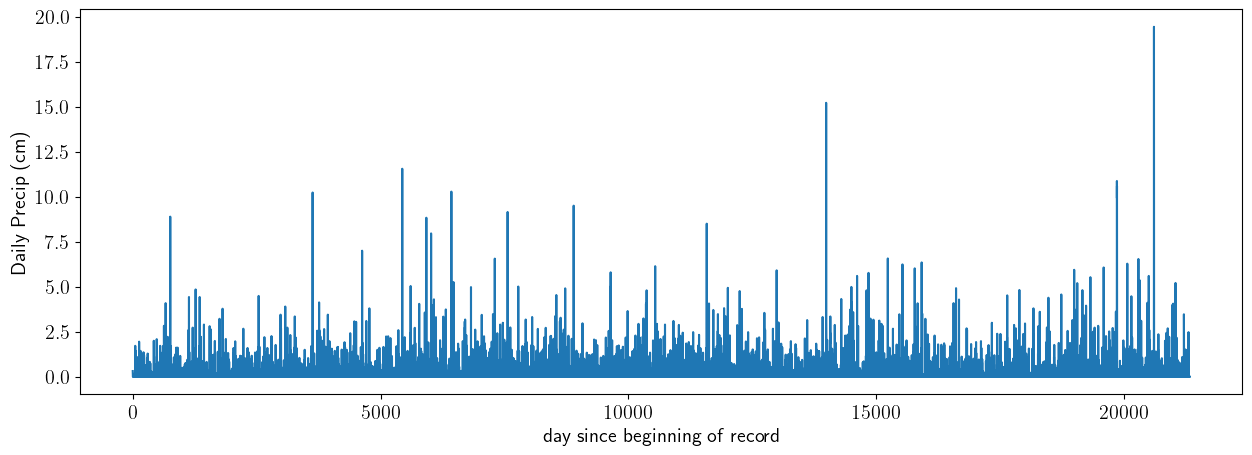

In [624]:
# plot raw precipitation
precip_raw=df['PRCP'].values
precip_raw=precip_raw[np.isnan(precip_raw)==False] # take out nans

fig,ax=plt.subplots(1,1)
ax.plot(precip_raw)
ax.set_xlabel('day since beginning of record')
ax.set_ylabel('Daily Precip (cm)')

Text(0, 0.5, 'count (number of days)')

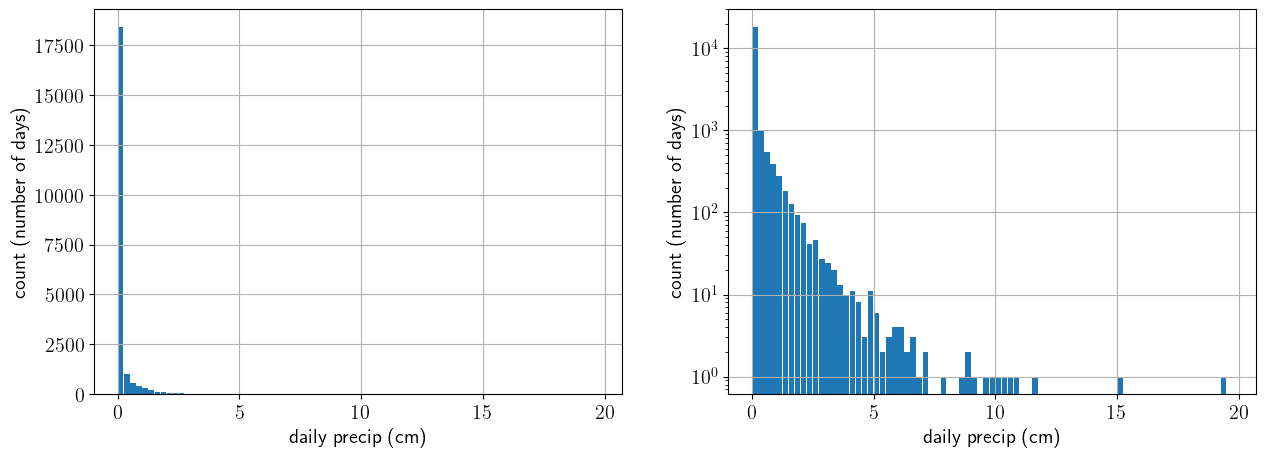

In [631]:
# Plot the histogram of the data. 
# For distributions such as a gamma distribution it makes sense to use a logarithmic axis.
#define bin edges and bin widths. 
# we'll use the maximum value in the data to define the upper limit

bin_edge_low=0
bin_edge_high=np.round(np.max(precip_raw)+1);
bin_width=0.25
bin_edges=np.arange(bin_edge_low,bin_edge_high,bin_width)

fig,ax=plt.subplots(1,2)
ax[0].hist(precip_raw,bin_edges,rwidth=0.9);
ax[0].set_xlabel('daily precip (cm)')
ax[0].set_ylabel('count (number of days)')
ax[0].grid()

ax[1].hist(precip_raw,bin_edges,rwidth=0.9)
ax[1].set_yscale('log')
ax[1].grid()
ax[1].set_xlabel('daily precip (cm)')
ax[1].set_ylabel('count (number of days)')

Text(0, 0.5, 'count (number of days)')

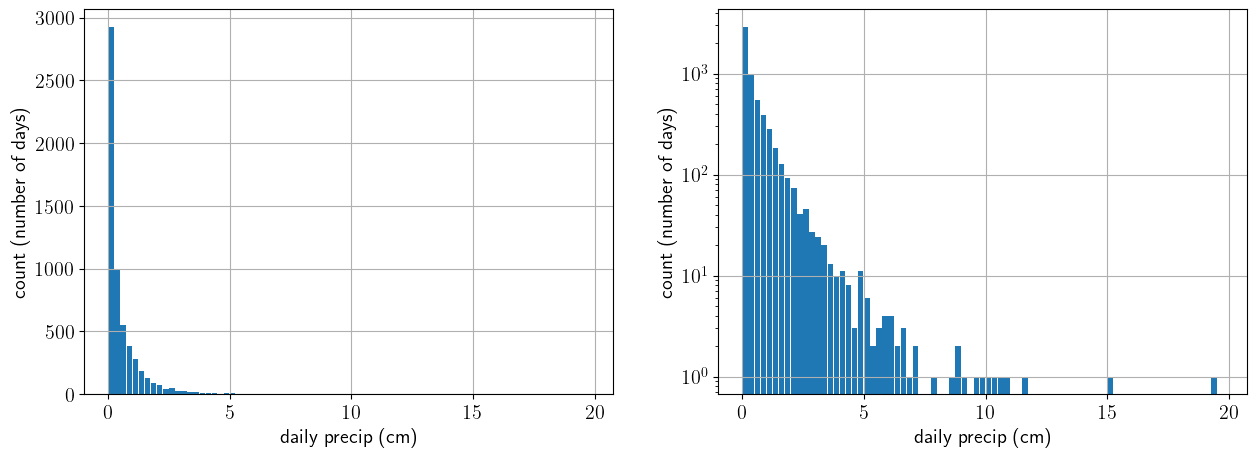

In [632]:
# the jump in the first bin indicates a probability mass at 0  ( a large number of days do not see any precipitation). 
# Let's only look at days when it rains. While we're at it, let's clean NaNs as well.
precip=precip_raw[precip_raw>0.01]

# Plot the histogram of the data
fig,ax=plt.subplots(1,2)
ax[0].hist(precip,bin_edges,rwidth=0.9);
ax[0].set_xlabel('daily precip (cm)')
ax[0].set_ylabel('count (number of days)')
ax[0].grid()
ax[0].set_xlabel('daily precip (cm)')
ax[0].set_ylabel('count (number of days)')

ax[1].hist(precip,bin_edges,rwidth=0.9)
ax[1].set_yscale('log')
ax[1].grid()
ax[1].set_xlabel('daily precip (cm)')
ax[1].set_ylabel('count (number of days)')


## Return times
What we want is to compute the return time of the rainiest day recorded at Beaumont Research Center (in years). 

What does this mean? The rainiest day at Beaumont brought $x$ cm. The return time represents how often we would expect to get $x$ cm or more of rain at Beaumont. To compute the return time we need to compute the probability of daily rain >$x$ cm, i.e. $P(\text{daily rain}>x\text{ cm})$. The inverse of this probability is the frequency of daily rain >$x$ cm. Let's give some examples:

-  if the probability of daily rain > 3 cm is $P(\text{daily rain}>3\text{ cm})=1/30$, it means we would expect that it rains 3 cm or more once about every 30 day, and we would say 3 cm is a 30 day event. 

-  i the probability of daily rain > 50 cm is $P(\text{daily rain}>50\text{ cm})=1/36500$, it means we would expect that it rains 3 cm or more once about every 36500 days, or once every 100 years, and we would say 50 cm of rain is 100 year event

Remember that the probability of daily rain being *less* than $x$ cm is given by the cumulative distribution function (CDF): $P(\text{daily rain}<x\text{ cm})=F(x)$, so the probability of rain being *more* than x is given by 1-F(x)$. 

So, all we have to do is fit a distribution to the data, and then use its CDF to compute return times. 

## Gamma Distribution

Precipitation is often modelled as a gamma distribution. The probability of observing a value $x_i$ given the three parameters of the gamma distribution: shape, scale, and location, $\theta={\alpha,\beta,x_o}$ is 

$$ p(x_i|\alpha,\beta,x_{0})=\frac{1}{\Gamma(\alpha)\beta^{\alpha}}\left(x_{i}-x_{0}\right)^{\alpha-1}\exp\left(\frac{-\left(x-x_{0}\right)}{\beta}\right) $$

For N independent events, the log-likelihood is: 

$$ \log\mathcal{L}=\sum_{i=1}^{N}\left(-\log\Gamma(\alpha)-\alpha\log\beta+\left(\alpha-1\right)\log\left(x_{i}-x_{o}\right)-\frac{\left(x_{i}-x_{o}\right)}{\beta}\right)$$

The log-likelihood of the gamma distribution includes the Gamma function. Computing the derivatives of the log-likelihood and setting them to zero requires numerical estimation. In practice, we will rarely compute MLEs by hand. For example, to fit a gamma distribution, we will use the <code>stats.gamma.fit</code> method to obtain maximum likelihood estimates for the parameters. 

The method will output the three parameters of the gamma random variable, shape,scale, and location, denoted in scipy as <code>a,loc,scale</code>,  (see documentation <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html"> here</a>). So you'll need to call it as <code>alpha_mle,loc_mle,scale_mle=stats.gama.fit( .... )</code>


[0.20740010390299995, 0.019999999999999997, 2.2682740851535863]


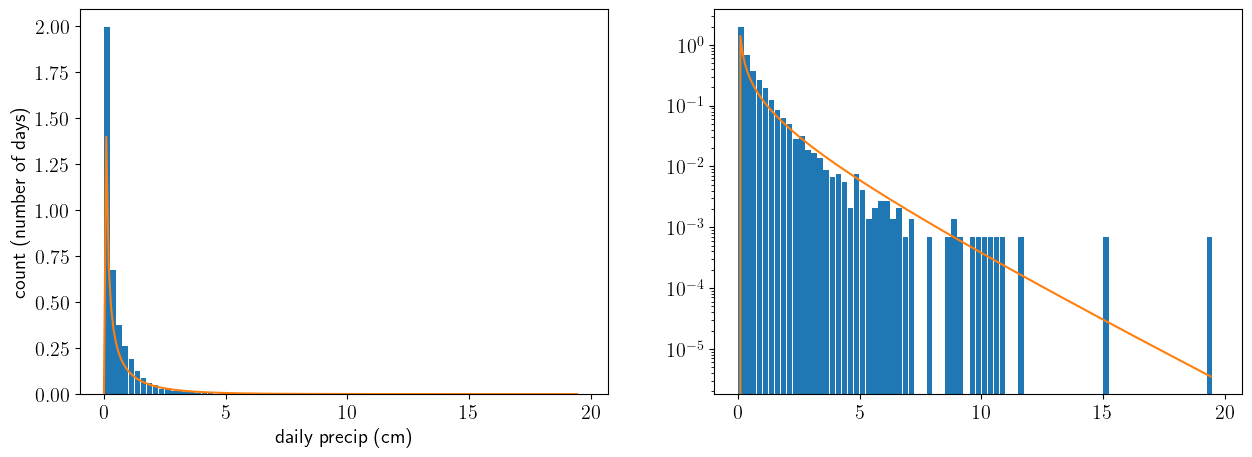

In [8]:
alpha_mle,loc_mle,scale_mle=stats.gamma.fit(precip)
print([alpha_mle,loc_mle,scale_mle])
x_plot=np.linspace(0,np.max(precip),200)
gamma_pdf=stats.gamma.pdf(x_plot,alpha_mle,loc_mle,scale_mle)


# Plot the histogram of the data
fig,ax=plt.subplots(1,2)
ax[0].hist(precip,bin_edges,rwidth=0.9,density=True);
ax[0].set_xlabel('daily precip (cm)')
ax[0].set_ylabel('count (number of days)')

ax[1].hist(precip,bin_edges,rwidth=0.9,density=True)
ax[1].set_yscale('log')

ax[0].plot(x_plot,gamma_pdf)
ax[1].plot(x_plot,gamma_pdf)


## Estimated return times
Now that we have an mle estimate for $\theta={\alpha,\beta,l}$, we can estimate the return times of the as the inverse of the probabiltiy that rain is equal to or exceeds the maximum observed precip. 

$$ \text{return time} =\frac{1}{1-F(\max\{x\}|\alpha_{mle},\beta_{mle},l_{mle})}$$


In [172]:
# Return times for Beumont
prob=1-stats.gamma.cdf(np.max(precip),alpha_mle,loc_mle,scale_mle)

# compute the return time (in days) and convert to years
1/prob/365


374.3981822070542

Let's repeat the analysis for the Port Arthur data. If you fit a Gamma ditribution and compute the return time of the largest daily rain event, what is the return time? 




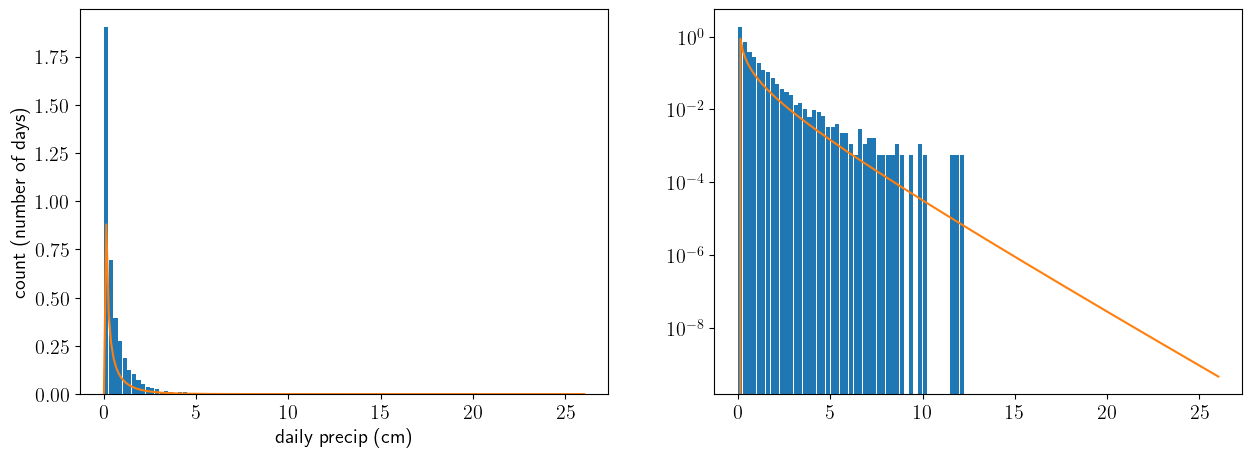

In [393]:
# read data and take a cursory look
df=pd.read_csv('https://raw.githubusercontent.com/cdds-uiuc/simles-book/main/content/Module02/data/PortArthur_precip.csv')
df.head()

# plot raw precipitation
precip_raw=df['PRCP'].values
precip_raw=precip_raw[np.isnan(precip_raw)==False] # take out nans
precip=precip_raw[precip_raw>0.01]


alpha_mle,loc_mle,scale_mle=stats.gamma.fit(precip)
x_plot=np.linspace(0,np.max(precip),200)
gamma_pdf=stats.gamma.pdf(x_plot,alpha_mle,loc_mle,scale_mle)


# Plot the histogram of the data
fig,ax=plt.subplots(1,2)
ax[0].hist(precip,bin_edges,rwidth=0.9,density=True);
ax[0].set_xlabel('daily precip (cm)')
ax[0].set_ylabel('count (number of days)')

ax[1].hist(precip,bin_edges,rwidth=0.9,density=True)
ax[1].set_yscale('log')

ax[0].plot(x_plot,gamma_pdf)
ax[1].plot(x_plot,gamma_pdf)


In [394]:
prob=1-stats.gamma.cdf(np.max(precip),alpha_mle,loc_mle,scale_mle)
1/prob/365

4080713.548079735

Does that seem reasonable? Why do you think the statistical model fails here? Think of the type of precipitation events that make up the precipitation data at Port Arthur